In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/IR_Project

/content/drive/.shortcut-targets-by-id/1CliGWiRMMrt25lPkcw94-tsFOEvjASWf/IR_Project


In [ ]:
ls

 Final_Data/                          Tweet_Dataset/
 final_preprocessed_tweet/           'Tweet Sentiment Analysis '/
 final_sentiment_tweet_crypto_data/   video_presentation/
 preprocYashBhavya/


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install -q transformers
import pandas as pd
from tqdm import tqdm
import re
import nltk
import matplotlib.pyplot as plt
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize.casual import EMOTICON_RE
from nltk.tokenize import RegexpTokenizer as reg
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
from transformers.pipelines.pt_utils import KeyDataset
from scipy.special import softmax
import urllib.request
import numpy as np
import csv


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
    
def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet) 

def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

def preprocess(files, keyword_set = None):
    files = list(files)
    preprocessed = []
    
    for file in files:
        file = remove_links(file)
        file = remove_users(file)
        preproc = file.lower()        

        found = False
        if(keyword_set is not None):
          for check in keyword_set:
              if(keyword_set is None):
                break
              if(check in preproc):
                found = True
                break
        
        preproc = re.sub('[^ $a-zA-Z0-9]','',preproc)
        # preproc = word_tokenize(preproc)
        preproc = preproc.split()
        
        # preproc = [word for word in preproc if not word in cache]
        new_preproc = []
        for word in preproc:
          new_preproc.append(word)

        if(not found and keyword_set is not None):
          new_preproc = None
        else:
          new_preproc = " ".join(new_preproc)

        preprocessed.append(new_preproc)
    
    return preprocessed

def parse_sentiment_output(output):
  labels=[]
  task='sentiment'
  mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
  with urllib.request.urlopen(mapping_link) as f:
      html = f.read().decode('utf-8').split("\n")
      csvreader = csv.reader(html, delimiter='\t')
  labels = [row[1] for row in csvreader if len(row) > 1]
  label = []
  score = []

  for i in output:
    if('1' in i['label']):
      label.append(labels[1])
    elif('2' in i['label']):
      label.append(labels[2])
    else:
      label.append(labels[0])

    score.append(i['score'])

  return label, score
  
def get_sentiment_score(tweet_column):
  task='sentiment'
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  
  MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
  tweet_list = list(tweet_column)

  sentiment_pipeline = pipeline("sentiment-analysis", model = MODEL, tokenizer = MODEL, device = 0)
  
  output = sentiment_pipeline(tweet_list)

  return output

def get_sentiment_score_mini_batch(tweet_column):
  task='sentiment'
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  
  MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
  tweet_list = list(tweet_column)
  sentiment_pipeline = pipeline("sentiment-analysis", model = MODEL, tokenizer = MODEL, device = 0)
  output = []
  for out in tqdm(sentiment_pipeline(tweet_list, batch_size=64), total=len(tweet_list)):
    output.append(out)

  return output

# Sentiment Analysis after finetuning

In [ ]:
avax_path = '/content/drive/MyDrive/IR_Project/final_preprocessed_tweet/Avalanche_combined_preproc.csv'
avax_data = pd.read_csv(avax_path)

In [ ]:
avax_data.head()

,Unnamed: 0.1,Unnamed: 0,id,text,favourite_count,retweet_count,created_at,User,place,time,...,volume_to,close,user_id_str,user_name,user_followers_count,user_verified,hashtags,mentioned,clean_tweet,changed_text
0,0,5571,1.509680e+18,@luigidemeo @DefiKingdoms @avalancheavax It's ...,2,0,2022-04-01 00:00:18,"{'id': 1368270387549732866, 'id_str': '1368270...",NaN,2022-04-01 00:01:00,...,262390.43,97.2,1368270387549732866,Mike( ͡◎ ͜ʖ ͡◎)🛸🔺,177,False,"['#AVALANCHE', '#AVALANCHE']","['@luigidemeo', '@DefiKingdoms', '@avalancheav...",short time achiev power union love new #avala...,short time achiev power union love new #avalan...
1,1,5570,1.509680e+18,@ConorMcGahey @Avalanche @AltitudeSR @DaveAMcC...,1,0,2022-04-01 00:00:20,"{'id': 358884012, 'id_str': '358884012', 'name...",NaN,2022-04-01 00:01:00,...,262390.43,97.2,358884012,Phil Park,2103,False,[],"['@ConorMcGahey', '@Avalanche', '@AltitudeSR',...",tune,tune
2,2,5569,1.509680e+18,DID YOU KNOW?\n\nYou can earn $HAKU from yiel...,12,0,2022-04-01 00:00:24,"{'id': 1284266461461192704, 'id_str': '1284266...",NaN,2022-04-01 00:01:00,...,262390.43,97.2,1284266461461192704,macaulay michael,1032,False,"['#Hakuswap', '#Avalanche']",[],know earn haku yield farm get lp token stake t...,know earn haku yield farm get lp token stake t...
3,3,5568,1.509680e+18,@ibamboozle_ @Avalanche @ColoradoEagles This i...,4,0,2022-04-01 00:00:29,"{'id': 612372852, 'id_str': '612372852', 'name...",NaN,2022-04-01 00:01:00,...,262390.43,97.2,612372852,lap,276,False,[],"['@ibamboozle_', '@Avalanche', '@ColoradoEagles']",genuin question go central team thread troll ...,genuin question go central team thread troll s...
4,4,5567,1.509680e+18,"Whether you’re chasing tanlines, big lines, or...",0,0,2022-04-01 00:00:51,"{'id': 757517948, 'id_str': '757517948', 'name...",NaN,2022-04-01 00:01:00,...,262390.43,97.2,757517948,Flathead Avalanche,872,False,"['#flatheadavalanche', '#fofac', '#topicsworks...",['@kalispellbrewingcompany'],whether you’r chase tanlin big line join us ne...,whether you’r chase tanlin big line join us ne...


In [ ]:
avax_data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'text', 'favourite_count',
       'retweet_count', 'created_at', 'User', 'place', 'time', 'high', 'low',
       'open', 'volume_from', 'volume_to', 'close', 'user_id_str', 'user_name',
       'user_followers_count', 'user_verified', 'hashtags', 'mentioned',
       'clean_tweet', 'changed_text'],
      dtype='object')

In [ ]:
avax_data['text'] = avax_data['text'].apply(str)

In [ ]:
avax_required_data = avax_data[['id','text', 'favourite_count', 'retweet_count', 'created_at', 'user_id_str', 'user_name', 'user_followers_count', 'user_verified', 'hashtags', 'mentioned']]
crypto_context = ['live', 'bitcoin', 'moon', 'crypto', 'avax', 'bitcoin', 'bit', 'ethereum', 'eth', 'liquidity', 'ecosystem', 'hodl', 'pump', 'whale', 'currency', '$', 'blockchain', 'block', 'chain', 'defi', 'nft', 'update', 'avalancheavax', 'token', 'project']
crypto_context = set(crypto_context)
avax_required_data['text'] = avax_required_data['text'].apply(str)
avax_preprocessed_text = preprocess(avax_required_data['text'], crypto_context)
avax_required_data['clean_text'] = avax_preprocessed_text
avax_required_data = avax_required_data.dropna()
avax_required_data.reset_index(inplace=True)
avax_required_data.to_csv('/content/drive/MyDrive/IR_Project/preprocYashBhavya/avax_preproc.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
avax_data = pd.read_csv('/content/drive/MyDrive/IR_Project/preprocYashBhavya/avax_preproc.csv')
avax_data['clean_text'] = avax_data['clean_text'].apply(str)
output = get_sentiment_score_mini_batch(avax_data['clean_text'])
avax_sentiment, avax_score = parse_sentiment_output(output)
avax_data['sentiment_label'] = avax_sentiment
avax_data['sentiment_score'] = avax_score
avax_data.to_csv('/content/drive/MyDrive/IR_Project/preprocYashBhavya/avax_sentiment.csv')

100%|██████████| 22229/22229 [00:00<00:00, 1505736.17it/s]


In [ ]:
doge_path = '/content/drive/MyDrive/IR_Project/final_preprocessed_tweet/DogeCoin_combined_preproc.csv'
doge_data = pd.read_csv(doge_path)
doge_required_data = doge_data[['id','text', 'favourite_count', 'retweet_count', 'created_at', 'user_id_str', 'user_name', 'user_followers_count', 'user_verified', 'hashtags', 'mentioned']]

doge_required_data['text'] = doge_required_data['text'].apply(str)
doge_preprocessed_text = preprocess(doge_required_data['text'])
doge_required_data['clean_text'] = doge_preprocessed_text
doge_required_data = doge_required_data.dropna()
doge_required_data.reset_index(inplace=True)
doge_required_data.to_csv('/content/drive/MyDrive/IR_Project/preprocYashBhavya/doge_preproc.csv')

doge_data = pd.read_csv('/content/drive/MyDrive/IR_Project/preprocYashBhavya/doge_preproc.csv')
doge_data['clean_text'] = doge_data['clean_text'].apply(str)
output = get_sentiment_score_mini_batch(doge_data['clean_text'])
doge_sentiment, doge_score = parse_sentiment_output(output)
doge_data['sentiment_label'] = doge_sentiment
doge_data['sentiment_score'] = doge_score
doge_data.to_csv('/content/drive/MyDrive/IR_Project/preprocYashBhavya/doge_sentiment.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 54305/54305 [00:00<00:00, 1348878.83it/s]


In [ ]:
solana_path = '/content/drive/MyDrive/IR_Project/final_preprocessed_tweet/Solana_combined_preproc.csv'
solana_data = pd.read_csv(solana_path)
solana_required_data = solana_data[['id','text', 'favourite_count', 'retweet_count', 'created_at', 'user_id_str', 'user_name', 'user_followers_count', 'user_verified', 'hashtags', 'mentioned']]

solana_required_data['text'] = solana_required_data['text'].apply(str)
solana_preprocessed_text = preprocess(solana_required_data['text'])
solana_required_data['clean_text'] = solana_preprocessed_text
solana_required_data = solana_required_data.dropna()
solana_required_data.reset_index(inplace=True)
solana_required_data.to_csv('/content/drive/MyDrive/IR_Project/preprocYashBhavya/solana_preproc.csv')

solana_data = pd.read_csv('/content/drive/MyDrive/IR_Project/preprocYashBhavya/solana_preproc.csv')
solana_data['clean_text'] = solana_data['clean_text'].apply(str)
output = get_sentiment_score_mini_batch(solana_data['clean_text'])
solana_sentiment, solana_score = parse_sentiment_output(output)
solana_data['sentiment_label'] = solana_sentiment
solana_data['sentiment_score'] = solana_score
solana_data.to_csv('/content/drive/MyDrive/IR_Project/preprocYashBhavya/solana_sentiment.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 182637/182637 [00:00<00:00, 2161699.88it/s]


In [ ]:
ripple_path = '/content/drive/MyDrive/IR_Project/final_preprocessed_tweet/Ripple_combined_preproc.csv'
ripple_data = pd.read_csv(ripple_path)
ripple_required_data = ripple_data[['id','text', 'favourite_count', 'retweet_count', 'created_at', 'user_id_str', 'user_name', 'user_followers_count', 'user_verified', 'hashtags', 'mentioned']]

ripple_required_data['text'] = ripple_required_data['text'].apply(str)
ripple_preprocessed_text = preprocess(ripple_required_data['text'])
ripple_required_data['clean_text'] = ripple_preprocessed_text
ripple_required_data = ripple_required_data.dropna()
ripple_required_data.reset_index(inplace=True)
ripple_required_data.to_csv('/content/drive/MyDrive/IR_Project/preprocYashBhavya/ripple_preproc.csv')

ripple_data = pd.read_csv('/content/drive/MyDrive/IR_Project/preprocYashBhavya/ripple_preproc.csv')
ripple_data['clean_text'] = ripple_data['clean_text'].apply(str)
output = get_sentiment_score_mini_batch(ripple_data['clean_text'])
ripple_sentiment, ripple_score = parse_sentiment_output(output)
ripple_data['sentiment_label'] = ripple_sentiment
ripple_data['sentiment_score'] = ripple_score
ripple_data.to_csv('/content/drive/MyDrive/IR_Project/preprocYashBhavya/ripple_sentiment.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 4021/4021 [00:00<00:00, 988297.47it/s]


# Word Cloud

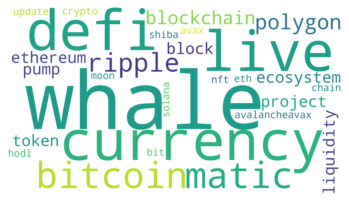

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
crypto_context = ['shiba', 'solana', 'avax', 'matic','polygon' , 'ripple','live', 'bitcoin', 'moon', 'crypto', 'avax', 'bitcoin', 'bit', 'ethereum', 'eth', 'liquidity', 'ecosystem', 'hodl', 'pump', 'whale', 'currency', '$', 'blockchain', 'block', 'chain', 'defi', 'nft', 'update', 'avalancheavax', 'token', 'project']
crypto_context = set(crypto_context)

text = set()

for i in crypto_context:
  all = list(map(str,i.split(',')))
  for j in range(len(all)):
    all[j].strip()
  
  for j in all: text.add(j)

string = ''
for i in text:
  string += i + " "

wc = WordCloud(background_color = 'white', width = 1920, height = 1080)
wc.generate_from_text(string)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# EDA

In [ ]:
import seaborn as sns

def value_vs_sentiment_graph(data):

  return 0

def retweets_vs_verified(data):
  return 0
solana = pd.read_csv('/content/drive/MyDrive/IR_Project/final_sentiment_tweet_crypto_data/solana_sentiment.csv')
solana.head(5)

,Unnamed: 0,Unnamed: 0.1,index,id,text,favourite_count,retweet_count,created_at,user_id_str,user_name,...,mentioned,high,low,open,volume_to,volume_from,close,clean_text,sentiment_label,sentiment_score
0,0,0,0,1.509680e+18,"Hey fam!, staking is on the way, and now it's ...",7,1,2022-04-01 00:00:00,1492964491574845442,Solana Faction Cards,...,[],122.77,122.33,122.74,460390.55,3757.19,122.33,hey fam staking is on the way and now its time...,neutral,0.866071
1,1,1,1,1.509680e+18,Follow us to receive Premium Signals from Top ...,0,0,2022-04-01 00:00:02,575197117,Crypto Signal Mall,...,[],122.77,122.33,122.74,460390.55,3757.19,122.33,follow us to receive premium signals from top ...,neutral,0.759371
2,2,2,2,1.509680e+18,"If you want to spend 0.04 $MATIC , You can min...",1,0,2022-04-01 00:00:02,1325342495316738049,Amouba NFT,...,[],122.77,122.33,122.74,460390.55,3757.19,122.33,if you want to spend 004 $matic you can mint a...,neutral,0.893176
3,3,3,3,1.509680e+18,Minting is live! 25% of minting proceeds will ...,3,2,2022-04-01 00:00:03,1463314448446332930,Chuck's Canucks,...,['@CWF_FCF'],122.77,122.33,122.74,460390.55,3757.19,122.33,minting is live 25 of minting proceeds will be...,neutral,0.508281
4,4,4,4,1.509680e+18,Current royalties 💰:\n36.75 SOL ≈ 4513.42 $\n\...,0,0,2022-04-01 00:00:03,1259533091842011141,MMCC REWARD STATUS,...,[],122.77,122.33,122.74,460390.55,3757.19,122.33,current royalties 3675 sol 451342 $meerkatmond...,neutral,0.890196


In [ ]:
solana.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'id', 'text', 'favourite_count',
       'retweet_count', 'created_at', 'user_id_str', 'user_name',
       'user_followers_count', 'user_verified', 'hashtags', 'mentioned',
       'high', 'low', 'open', 'volume_to', 'volume_from', 'close',
       'clean_text', 'sentiment_label', 'sentiment_score'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


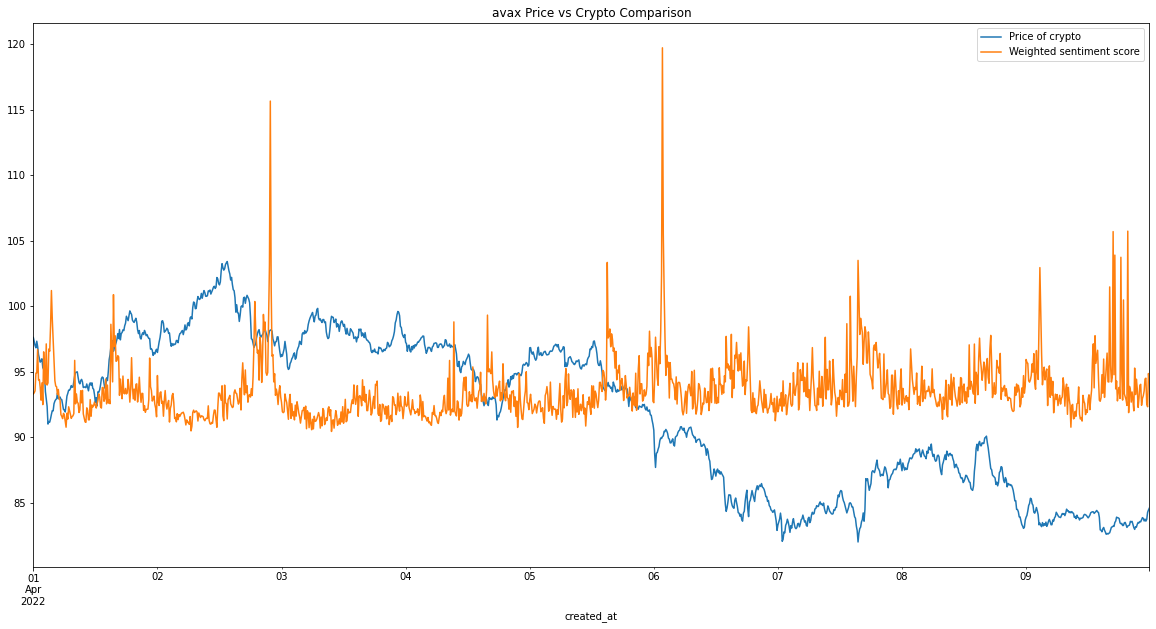

In [ ]:
crypto = ["solana","shiba","ripple","doge","matic","avax"]
for i in crypto:
  solana = pd.read_csv(f'/content/drive/MyDrive/IR_Project/final_sentiment_tweet_crypto_data/{i}_sentiment.csv',low_memory=False)
  solana = solana.sort_values(by="created_at")
  solana  = solana.iloc[1:-1,:]
  solana['polarity'] = np.zeros(len(solana))
  solana['req_price'] = (solana['high'] + solana['low'])/2

  solana['sent_copy'] = solana['sentiment_label']
  solana['polarity'][solana['sent_copy'] == 'neutral'] = 0.1
  solana['polarity'][solana['sent_copy'] == 'positive'] = 0.2
  solana['polarity'][solana['sent_copy'] == 'negative'] = 0
  solana['net_score'] = solana['polarity'] * solana['sentiment_score']
  solana['created_at'] = pd.to_datetime(solana['created_at'])

  req1= solana[['created_at', 'req_price']]
  req1 = req1.groupby(pd.Grouper(key='created_at', freq='10min')).mean()
  # req1['created_at'] = req1.index

  req = solana[['created_at', 'net_score']]
  req = req.groupby(pd.Grouper(key='created_at', freq='10min')).sum()
  # req['created_at'] = req.index

  req['req_price'] = req1['req_price']
  req['created_at'] = req.index
  req['net_score'] += 90

  req.plot(x='created_at', y=['req_price', 'net_score'])
  plt.legend(['Price of crypto', 'Weighted sentiment score'])
  plt.gcf().set_size_inches(20,10)
  plt.title(i+" Price vs Crypto Comparison")
  plt.show()

In [ ]:
Dsolana = pd.read_csv(f'/content/drive/MyDrive/IR_Project/final_sentiment_tweet_crypto_data/avax_sentiment.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,6,8,10,11,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# solana.dropna(axis=1)
solana = solana.sort_values(by="created_at")
solana
# for i in solana["created_at"]:
#   if(pd.to_datetime(i)):
#     print(i)
# print(solana['created_at'])
# solana['created_at'] = pd.to_datetime(solana['created_at'])

# solana/
# solana = solana.iloc[:-1,:]


,Unnamed: 0,Unnamed: 0.1,index,id,text,favourite_count,retweet_count,created_at,user_id_str,user_name,...,mentioned,high,low,open,volume_to,volume_from,close,clean_text,sentiment_label,sentiment_score
20642,20642,. Their ecosystem offers fast trading with one...,0,0.000000e+00,2022-04-05 17:03:58,1.412520e+18,SunEve,11,False,['#Avalanche'],...,93.62,89725.12,958.56,93.60,you know that $nhct is from avalanche their ec...,NaN,NaN,NaN,neutral,0.528188
0,0,0,0,1.509680e+18,@luigidemeo @DefiKingdoms @avalancheavax It's ...,2.000000e+00,0,2022-04-01 00:00:18,1368270387549732866,Mike( ͡◎ ͜ʖ ͡◎)🛸🔺,...,"['@luigidemeo', '@DefiKingdoms', '@avalancheav...",97.63,97.20,97.63,262390.43,2696.72,97.20,its been a short time to achieve such a powerf...,positive,0.983468
1,1,1,1,1.509680e+18,@ConorMcGahey @Avalanche @AltitudeSR @DaveAMcC...,1.000000e+00,0,2022-04-01 00:00:20,358884012,Phil Park,...,"['@ConorMcGahey', '@Avalanche', '@AltitudeSR',...",97.63,97.20,97.63,262390.43,2696.72,97.20,i will be tuned in,neutral,0.638937
2,2,2,2,1.509680e+18,DID YOU KNOW?\n\nYou can earn $HAKU from yiel...,1.200000e+01,0,2022-04-01 00:00:24,1284266461461192704,macaulay michael,...,[],97.63,97.20,97.63,262390.43,2696.72,97.20,did you knowyou can earn $haku from yield farm...,neutral,0.805272
3,3,3,3,1.509680e+18,@ibamboozle_ @Avalanche @ColoradoEagles This i...,4.000000e+00,0,2022-04-01 00:00:29,612372852,lap,...,"['@ibamboozle_', '@Avalanche', '@ColoradoEagles']",97.63,97.20,97.63,262390.43,2696.72,97.20,this is a genuine question do you go into all ...,neutral,0.677839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44321,44321,44320,44322,1.512943e+18,One line strategy; “Don’t jump over the pump”....,3.000000e+00,0,2022-04-09 23:58:08,1397678033524330498,Saqib Omer Saeed,...,[],84.65,84.55,84.65,10819.41,127.91,84.56,one line strategy dont jump over the pumpcrypt...,neutral,0.870568
44322,44322,44321,44323,1.512943e+18,Don’t know if I tweet this earlier but here’s ...,0.000000e+00,0,2022-04-09 23:58:13,1421621964611936268,STACKMASTER,...,[],84.65,84.55,84.65,10819.41,127.91,84.56,dont know if i tweet this earlier but heres to...,neutral,0.530305
44323,44323,44322,44324,1.512943e+18,Check out our Avalanche April Newsletter to re...,1.000000e+00,0,2022-04-09 23:58:14,280646065,UtahAvalancheSoccer,...,[],84.65,84.55,84.65,10819.41,127.91,84.56,check out our avalanche april newsletter to re...,neutral,0.840291
44324,44324,44323,44325,1.512943e+18,Puffy #5294 sold for 1.09 AVAX. \nhttpsSkeptic...,0.000000e+00,0,2022-04-09 23:58:31,1504974086321152002,CryptoPuffies Sales Bot🔺,...,[],84.65,84.55,84.65,10819.41,127.91,84.56,puffy 5294 sold for 109 avax,neutral,0.884582


# Retweet and favourite analysis

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'id', 'text', 'favourite_count',
       'retweet_count', 'created_at', 'user_id_str', 'user_name',
       'user_followers_count', 'user_verified', 'hashtags', 'mentioned',
       'high', 'low', 'open', 'volume_to', 'volume_from', 'close',
       'clean_text', 'sentiment_label', 'sentiment_score'],
      dtype='object')


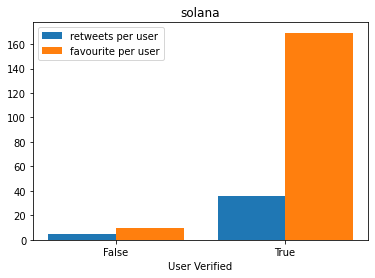

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'id', 'text', 'favourite_count',
       'retweet_count', 'created_at', 'user_id_str', 'user_name',
       'user_followers_count', 'user_verified', 'hashtags', 'mentioned',
       'high', 'low', 'open', 'volume_to', 'volume_from', 'close',
       'clean_text', 'sentiment_label', 'sentiment_score'],
      dtype='object')


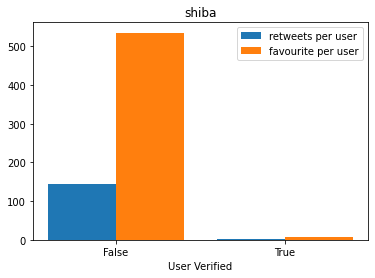

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'id', 'text', 'favourite_count',
       'retweet_count', 'created_at', 'user_id_str', 'user_name',
       'user_followers_count', 'user_verified', 'hashtags', 'mentioned',
       'high', 'low', 'open', 'volume_to', 'volume_from', 'close',
       'clean_text', 'sentiment_label', 'sentiment_score'],
      dtype='object')


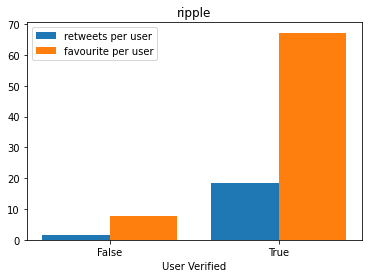

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'id', 'text', 'favourite_count',
       'retweet_count', 'created_at', 'user_id_str', 'user_name',
       'user_followers_count', 'user_verified', 'hashtags', 'mentioned',
       'high', 'low', 'open', 'volume_to', 'volume_from', 'close',
       'clean_text', 'sentiment_label', 'sentiment_score'],
      dtype='object')


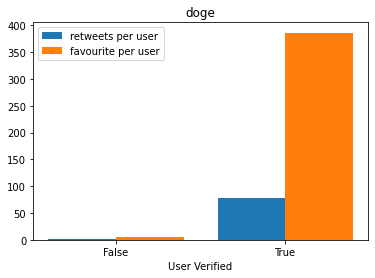

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'id', 'text', 'favourite_count',
       'retweet_count', 'created_at', 'user_id_str', 'user_name',
       'user_followers_count', 'user_verified', 'hashtags', 'mentioned',
       'high', 'low', 'open', 'volume_to', 'volume_from', 'close',
       'clean_text', 'sentiment_label', 'sentiment_score'],
      dtype='object')


KeyError: ignored

In [ ]:
crypto = ["solana","shiba","ripple","doge","matic"]
for i in crypto:
  solana = pd.read_csv(f'/content/drive/MyDrive/IR_Project/final_sentiment_tweet_crypto_data/{i}_sentiment.csv',low_memory=False)
  print(solana.columns)
  retweet_verified = solana[['user_verified', 'retweet_count', 'favourite_count']]
  count = retweet_verified.user_verified.value_counts()
  verified_retweet = retweet_verified.groupby(pd.Grouper(key='user_verified')).sum()
  verified_retweet['user_verified_count'] = count
  verified_retweet['retweets_per_user'] = verified_retweet['retweet_count'] / verified_retweet['user_verified_count']
  verified_retweet['favourite_per_user'] = verified_retweet['favourite_count'] / verified_retweet['user_verified_count']
  verified_retweet['user_verified'] = verified_retweet.index
  verified_retweet = verified_retweet.drop(['retweet_count', 'favourite_count', 'user_verified_count'], axis = 1)

  X = ['retweets_per_user', 'favourite_per_user']
  Z = ['False', 'True']
  X_axis = np.arange(len(X))
  plt.xticks(X_axis, Z)
  plt.bar(X_axis - 0.2, verified_retweet['retweets_per_user'], 0.4, label = 'retweets per user')
  plt.bar(X_axis + 0.2, verified_retweet['favourite_per_user'], 0.4, label = 'favourite per user')
  plt.xlabel("User Verified")
  plt.title(i)
  plt.legend()
  plt.show()